In [77]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from scipy.stats import kendalltau


In [246]:
def hstar(Z, gram_mat=False):
    n = Z.shape[0]
    if not gram_mat:
        _, s, _ = np.linalg.svd(Z / np.sqrt(n))
        evals = s**2
    else:
        _, evals, _ = np.linalg.svd(Z / n)
    
    vec = np.asarray([
        i / n + np.sqrt(np.sum(evals[i:]) / n) for i in range(len(evals)+1)
    ])
    idx = np.argmin(vec)

    return vec[idx], idx

def get_tree_Z(clf, X):
    n = X.shape[0]
    leaf_indices = clf.apply(X)
    Z = np.zeros((n, len(set(leaf_indices))))
    Z[np.arange(n), np.unique(leaf_indices, return_inverse=True)[1]] = 1
    
    return Z

def get_forest_Z(clf, X):
    n = X.shape[0]
    Z_forest = np.zeros((n, n))
    for tree in clf.estimators_:
        leaf_indices = tree.apply(X)
        Z = np.zeros((n, len(set(leaf_indices))))
        Z[np.arange(n), np.unique(leaf_indices, return_inverse=True)[1]] = 1
        Z_forest += Z @ Z.T
    Z_forest /= len(clf.estimators_)
    
    return Z_forest

In [205]:
n = 100
hstars = []
n_unique_regions = []
mus = np.linspace(0, 2, 21)
gen_errors = []
for mu in mus:
    center = np.asarray([mu, 0])
    X, y = make_blobs(
        n_samples=[n // 2, n // 2],
        centers=[-center, center],
        n_features=2,
        random_state=0)
    
    X_test, y_test = make_blobs(
        n_samples=[1000, 1000],
        centers=[-center, center],
        n_features=2,
        random_state=1)
#     plt.scatter(X[:, 0], X[:, 1], c=y)
#     plt.title(f'mu={mu}')
#     plt.show()
#     clf = DecisionTreeClassifier().fit(X, y)
#     Z = get_tree_Z(clf, X)
#     hstars.append(hstar(Z))
    clf = RandomForestClassifier(n_estimators=10).fit(X, y)
    Z = get_forest_Z(clf, X)
    hstars.append(hstar(Z, gram_mat=True))
    gen_errors.append(1 - clf.score(X_test, y_test))
    n_unique_regions.append(Z.shape[1])
    
hstar_list, min_h_list = zip(*hstars)

[7 5 4 4]
[7 5 5 4]
[6 5 5 4]
[9 5 4 4]
[6 6 5 4]
[12  8  5  4]
[16  8  5  4]
[13  9  5  5]
[17 11  4  4]
[23 11  5  5]
[25 11  5  5]
[28 14  7  5]
[32 16  6  5]
[28 20  8  6]
[37 29  6  3]
[34 25 10  5]
[40 35  5  3]
[36 33  7  4]
[34 33  8  7]
[35 32  8  7]
[37 36  8  7]


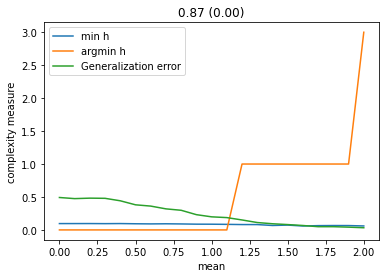

In [206]:
plt.plot(mus, hstar_list, label='min h')
plt.plot(mus, min_h_list, label='argmin h')
plt.plot(mus, gen_errors, label='Generalization error')
# plt.plot(mus, n_unique_regions, label='unique regions')
corr, pval = kendalltau(gen_errors, hstar_list)
plt.title(f'{corr:.2f} ({pval:.2f})')
# plt.yscale('symlog')
plt.legend()
plt.xlabel('mean')
plt.ylabel('complexity measure')
plt.show()

[55 45]


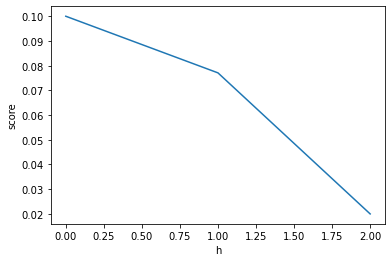

[45 45 10]


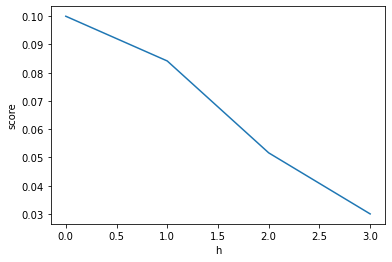

[45 45  7  3]


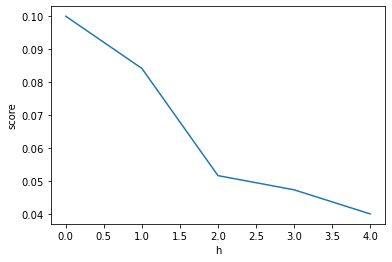

[45 45  5  3]


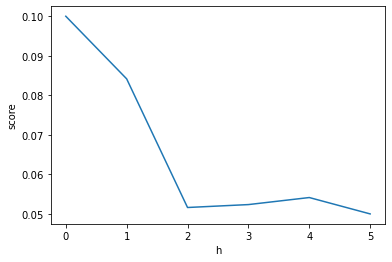

[45 44  5  3]


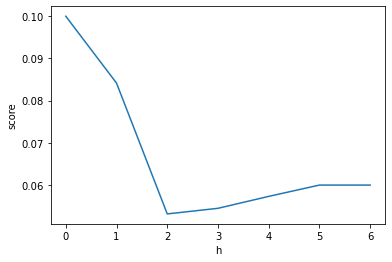

[45 36  8  5]


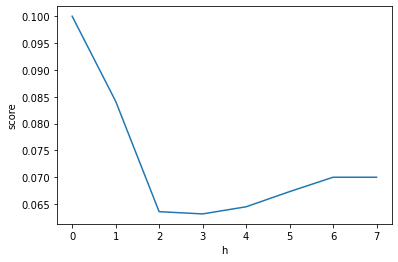

[45 36  7  5]


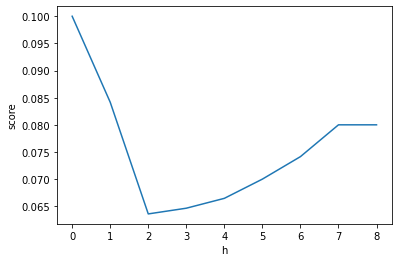

[36 34 11  7]


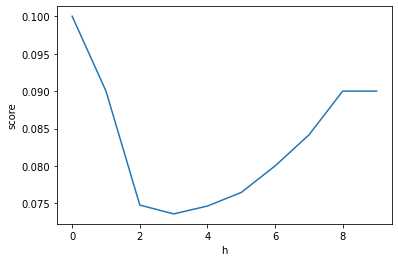

[36 34 10  7]


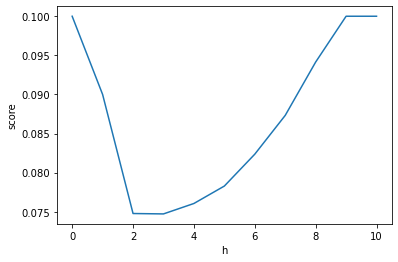

[36 34  7  7]


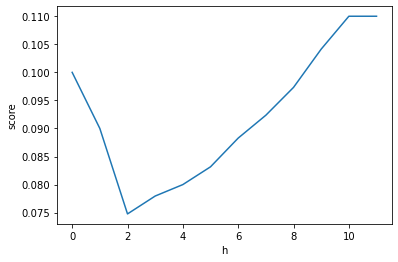

[36 34  7  7]


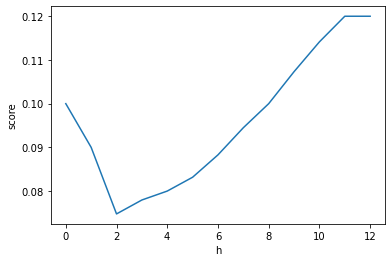

[36 34  7  5]


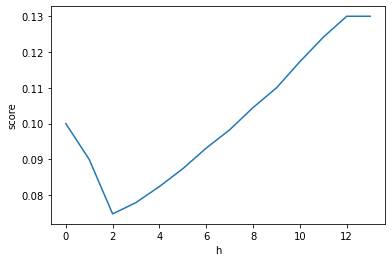

[36 34  7  5]


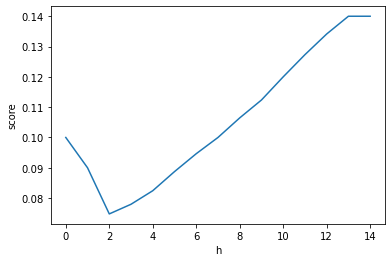

[36 20 14  7]


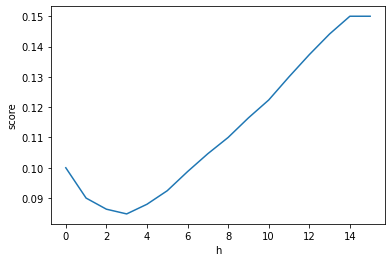

[36 20 13  7]


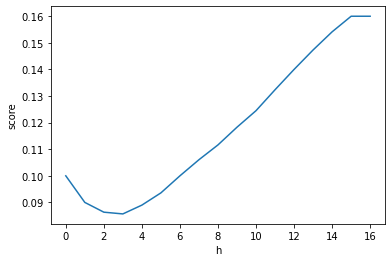

[36 20 12  7]


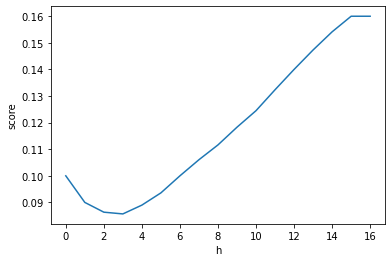

[36 20 12  7]


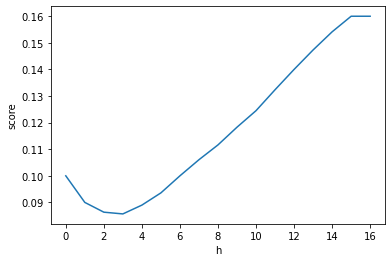

[36 20 13  7]


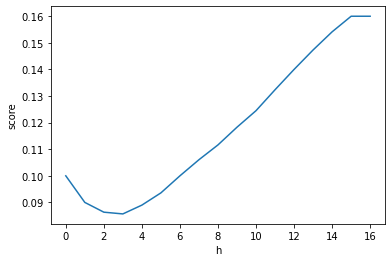

[36 20 12  7]


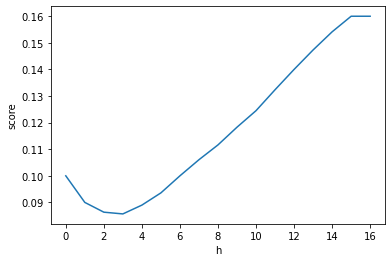

[36 20 12  7]


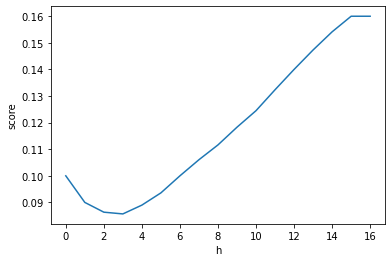

[36 20 12  7]


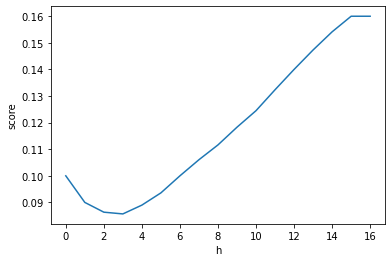

[36 20 13  7]


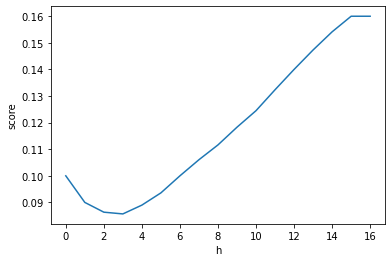

[36 20 13  7]


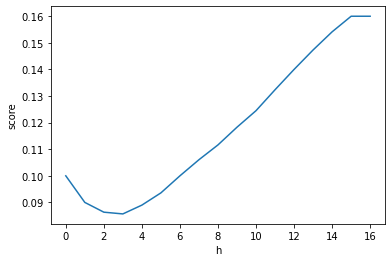

[36 20 13  7]


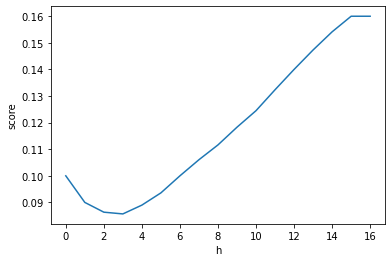

[36 20 12  7]


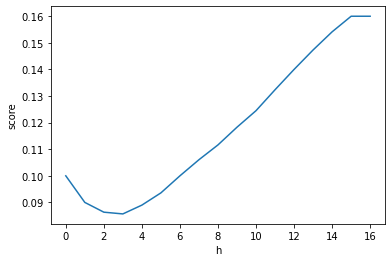

[36 20 12  7]


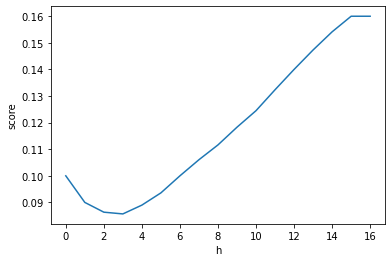

[36 20 12  7]


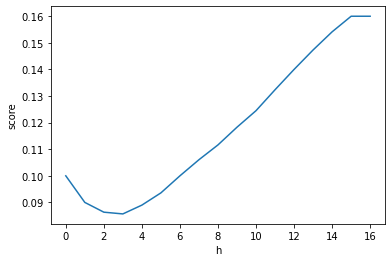

[36 20 12  7]


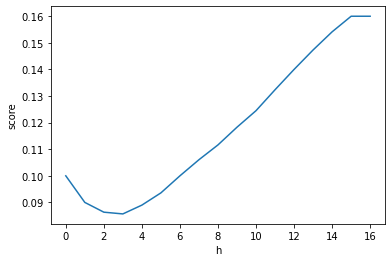

In [227]:
n = 100
mu = 1
center = np.asarray([mu, 0])
X, y = make_blobs(
    n_samples=[n // 2, n // 2],
    centers=[-center, center],
    n_features=2,
    random_state=None)

X_test, y_test = make_blobs(
    n_samples=[1000, 1000],
    centers=[-center, center],
    n_features=2,
    random_state=None)

hstars = []
gen_errors = []
n_nodes = np.arange(2, 30)
for max_nodes in n_nodes:
    center = np.asarray([mu, 0])
    
#     plt.scatter(X[:, 0], X[:, 1], c=y)
#     plt.title(f'mu={mu}')
#     plt.show()
    clf = DecisionTreeClassifier(max_leaf_nodes=max_nodes).fit(X, y)
    Z = get_tree_Z(clf, X)
    hstars.append(hstar(Z))
#     clf = RandomForestClassifier(n_estimators=10).fit(X, y)
#     Z = get_forest_Z(clf, X)
#     hstars.append(hstar(Z, gram_mat=True))
    n_unique_regions.append(Z.shape[1])
    gen_errors.append(1 - clf.score(X_test, y_test))
    
hstar_list, min_h_list = zip(*hstars)

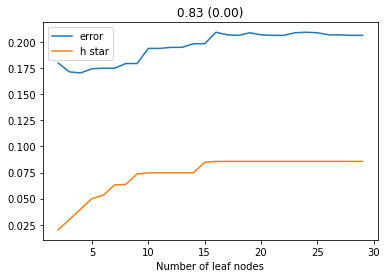

In [228]:
plt.plot(n_nodes, gen_errors, label='error')
# plt.plot(n_nodes, min_h_list, label='argmin h')
plt.plot(n_nodes, hstar_list, label='h star')
# plt.yscale('symlog')
plt.legend()
plt.ylabel('')
plt.xlabel('Number of leaf nodes')
corr, pval = kendalltau(gen_errors, hstar_list)
plt.title(f'{corr:.2f} ({pval:.2f})')
plt.show()

## Bayes XOR classifier

In [191]:
n = 100
evals = [n//4] * 4 + [0] * (n - 4)

h_scores = np.asarray([
    i / n + np.sqrt(np.sum(evals[i+1:]) / n) for i in range(len(evals))
])
argmin_h = np.argmin(h_scores)

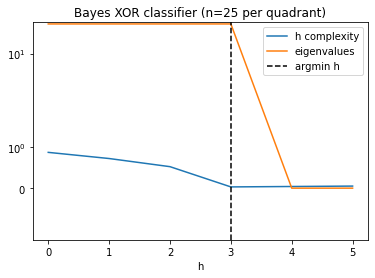

In [196]:
plt.plot(np.arange(0, 6), h_scores[:6], label='h complexity')
plt.plot(np.arange(0, 6), evals[:6], label='eigenvalues')
plt.axvline(argmin_h, label='argmin h', ls='--', c='black')
plt.title(f'Bayes XOR classifier (n={n//4} per quadrant)')
plt.legend()
plt.xlabel('h')
plt.yscale('symlog')
plt.show()

## Complexity of ensemble

In [253]:
from sklearn.datasets import *
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns

In [230]:
loaders = [load_iris, load_digits, load_wine, load_breast_cancer]

In [286]:
columns = ['Dataset', 'Method', 'leaves / n', 'h star', 'argmin h', 'test_error', 'train_error', 'n']
df_mat = []
for loader in loaders:
    dataset = loader.__name__[5:]
    print(dataset)
    X, y = loader(return_X_y = True)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=42)
    n = X_train.shape[0]
    n_leaves_list = np.logspace(1, np.log2(n), num=10, base=2).astype(int)
    
    for n_leaves in n_leaves_list:
        # Train model
        clf = RandomForestClassifier(
            n_estimators=20,
            max_leaf_nodes=n_leaves,
            bootstrap=False
        ).fit(X_train, y_train)
        
        # Extract ensemble results
        test_error = 1 - clf.score(X_test, y_test)
        train_error = 1 - clf.score(X_train, y_train)
        Z = get_forest_Z(clf, X)
        h_star, argmin_h = hstar(Z, gram_mat=True)
        
        df_mat.append([dataset, 'Forest', n_leaves/n, h_star, argmin_h, test_error, train_error, n])
        
        # Extract tree-wise results
        for tree in clf.estimators_:
            test_error = 1 - tree.score(X_test, y_test)
            train_error = 1 - tree.score(X_train, y_train)
            Z = get_tree_Z(tree, X)
            h_star, argmin_h = hstar(Z)
            
            df_mat.append([dataset, 'Tree', n_leaves/n, h_star, argmin_h, test_error, train_error, n])

iris
digits
wine
breast_cancer


In [307]:
df = pd.DataFrame(df_mat, columns=columns)
df['generalization_gap'] = df['test_error'] - df['train_error']

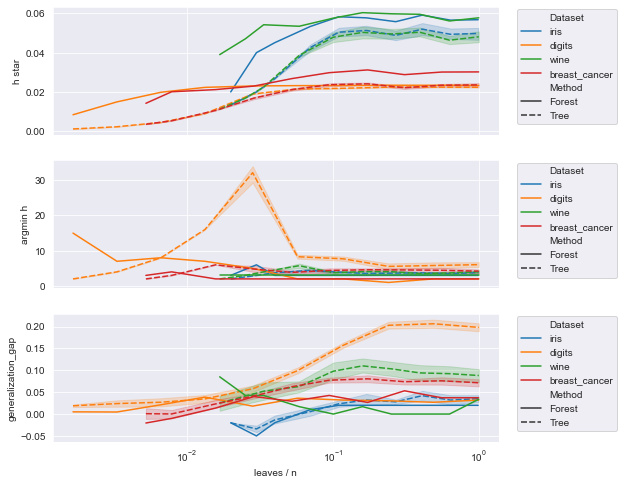

In [313]:
sns.set_style('darkgrid')
fig, axes = plt.subplots(3, 1, figsize=(8, 8), sharex=True)
for ax, y in zip(axes, ['h star', 'argmin h', 'generalization_gap']):
    sns.lineplot(data=df, x='leaves / n', y=y, ax=ax, hue='Dataset', style='Method')
    ax.legend(loc='upper left', bbox_to_anchor=(1.03, 1.02))
    ax.set_xscale('log')
    # ax.set_yscale('symlog')

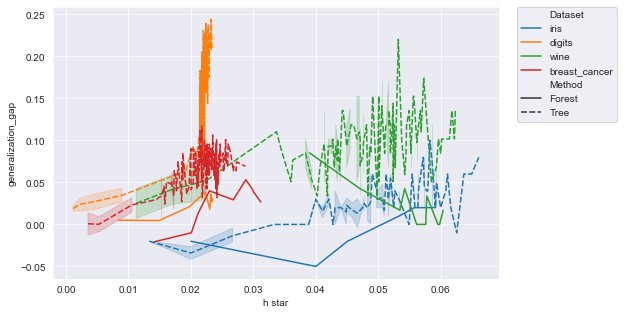

In [316]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
sns.lineplot(data=df, x='h star', y='generalization_gap', ax=ax, hue='Dataset', style='Method')
ax.legend(loc='upper left', bbox_to_anchor=(1.03, 1.02))
# ax.set_yscale('symlog')

In [310]:
for dataset in df['Dataset'].unique():
    for method in df['Method'].unique():
        df_temp = df[(df['Method'] == method) & (df['Dataset'] == dataset)]#.corr(method='kendall')
        df_temp = df_temp.groupby('leaves / n').mean()
        corr, pval = kendalltau(df_temp['generalization_gap'], df_temp['h star'])

        print(f'{dataset} ({method}): {corr:.2f} ({pval:.2f})')

iris (Forest): 0.75 (0.01)
iris (Tree): 0.76 (0.00)
digits (Forest): 0.27 (0.28)
digits (Tree): 1.00 (0.00)
wine (Forest): -0.51 (0.05)
wine (Tree): 0.78 (0.00)
breast_cancer (Forest): 0.36 (0.15)
breast_cancer (Tree): 0.87 (0.00)
